In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

# Template: Plot metrics, poke the model 

This file provides a template of how to look at all the metrics of a model. The functions here can be used **while the model is still training**. If it works on your computer, you can use `%matplotlib interactive` to pan the figures in the browser.

To use it, it is advised to first **copy** the notebook to something else specific to your experiment, and leave this template alone.

In [37]:
# 14: full-batch HMC, fairly good acceptance probability
# 4: SG-HMC, crap acceptance probability

log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_21_mnist_doublegamma/12") # was 4

## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [38]:
with open(log_dir/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                                "model",
                                "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                                "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                                "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")

Loaded model of kind correlatedclassificationconvnet


In [39]:
sizes = plot.get_sizes(model)


## Plot metrics

First we load the metrics, then we plot various aspects of them.

In [40]:
# Locate the samples and metrics' meta data in disk.
try:
    metrics = h5py.File(log_dir/"metrics.h5", "r", swmr=True)
except OSError as e:
    raise RuntimeError("Perhaps you have to wait 120 seconds for the metrics to begin saving?")
metrics.keys()

<KeysViewHDF5 ['acc', 'acceptance', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'test', 'timestamps']>

In [41]:
is_sample_mask = mask = (metrics['acceptance/is_sample'][:] == 1)
# This is where the samples have been taken (and accepted or rejected:)

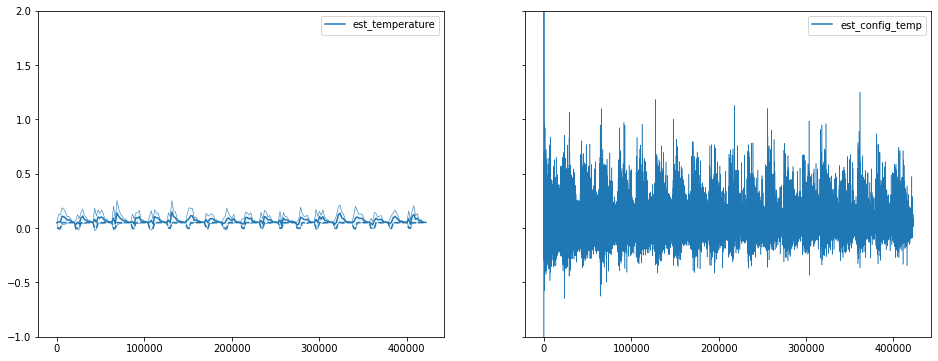

In [45]:
_, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plot.temperature_stderr(axes[0], metrics, "est_temperature", sizes, ewma_alpha=0.0, mask=slice(None, None, 200))
axes[0].set_ylim((, 2))
plot.temperature_stderr(axes[1], metrics, "est_config_temp", sizes, ewma_alpha=0.0, mask=slice(None))

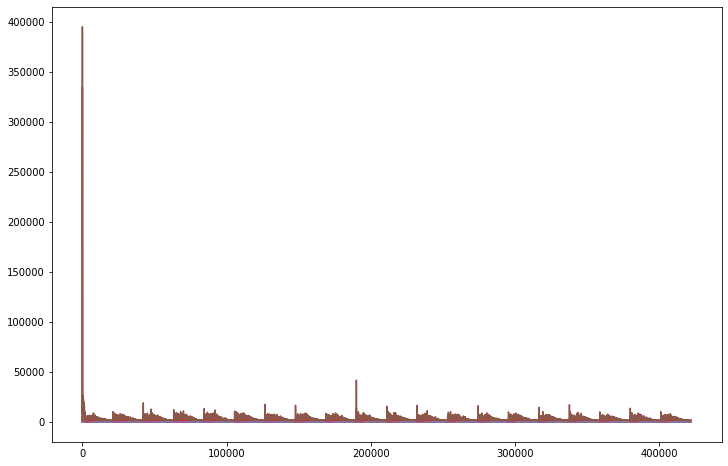

In [43]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))


for k in metrics["est_temperature"].keys():
    if k == "all":
        continue
    plot.metric(ax, metrics, "est_temperature/"+k,
                transform=lambda x: x*sizes[k], legend=False)

/scratches/huygens/ag919/BNN-priors/bnn_priors/plot.py:117: RuntimeWarning: divide by zero encountered in true_divide
  adjusted_temp = (metrics["est_temperature"][k][mask] / temperature)


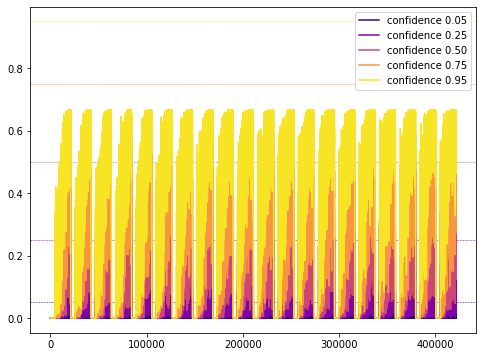

In [46]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))

plot.kinetic_temperature_intervals(ax, metrics, sizes, mask=slice(None), ewma_alpha=0.5)

KeyError: "Unable to open object (object 'delta_energy' doesn't exist)"

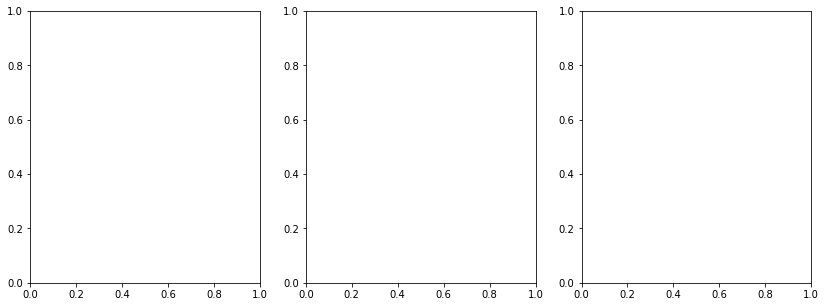

In [14]:
_, axes = plt.subplots(1, 3, figsize=(14, 5))

def accept_prob(x):
    return np.exp(np.minimum(0., -x))

plot.metric(axes[0], metrics, "delta_energy", transform=accept_prob,
            plot_kwargs=dict(label="accept prob."), mask=is_sample_mask)

plot.metric(axes[1], metrics, "delta_energy", mask=slice(None, None, 800), ewma_alpha=0.0)
plot.vlines(axes[1], metrics, is_sample_mask)

plot.metric(axes[2], metrics, "total_energy", mask=slice(None))

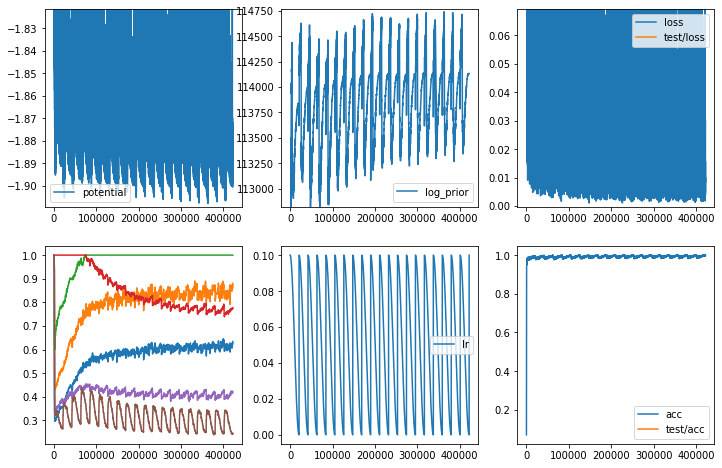

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

mask = slice(None)

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2., mask=mask)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2., mask=mask)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=mask, iqr_ylim=2.)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, mask=mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr', mask=mask)

plot.metric(axes[1, 2], metrics, 'acc', mask=mask, ewma_alpha=0.9)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=mask)

In [22]:
"average acceptance", 1-np.mean(metrics["acceptance/rejected"][mask])

KeyError: "Unable to open object (object 'rejected' doesn't exist)"

In [29]:
samples = h5py.File(log_dir/"samples.pt", "r", swmr=True)

In [36]:
samples['net.module.conv1.weight_prior.p'][60]

array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       ...,


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan

In [ ]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)


## Load and poke the model

In [ ]:
del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *remove* .module. from the key
    for k in list(state_dict_samples.keys()):
        if k.startswith("net.module."):
            state_dict_samples["net." + k.lstrip("net.module.")] = state_dict_samples[k]
            del state_dict_samples[k]

In [ ]:
model.load_state_dict({k: v[-1] for k, v in state_dict_samples.items()})